# Data Science Project: Artist Style Classification
50.038 Computational Data Science

By:
Lee Chien Shyong 1005903
Khoo Zi Qi 1006984

### 1. Dataset Selection and Collection

We collected artworks from three specific artists using `gallery-dl`, a command-line program to download imaged from image hosting sites.

**Source:** Scraped from Danbooru, a large online image board and database focused on anime-style artwork, where users can upload, tag, and categorize images for easy searching and exploration.

**Dataset Type:** Image dataset consisting of high-quality images in folders labeled with artist names.  

#### Scraping Process 
We used the following command to scrape images:  
```bash
gallery-dl "https://danbooru.donmai.us/posts?tags=<artist_name>+rating:general"
```
To filter images and ensure data consistency, we preprocessed the dataset by:  
- Removing corrupted images  
- Standardizing image dimensions  



### 2. Problem Statement
The goal of this project is to **understand and classify artist styles**. Specifically, we aim to:  
- Identify **visual patterns** that make an artist's style unique  
- Train a model to **distinguish between artworks** from different artists  
- Explore why **certain artistic features** are more recognizable than others  



### Baseline Model: Image Classification using Keras
We implement a **naïve model** inspired by the **Keras Tutorial: Image Classification from Scratch** (Week 6 Lab).  

#### Approach:
- Use `image_dataset_from_directory` to load and preprocess the dataset  
- Train a Convulational Neural Network(CNN) model **from scratch**, similar to the **Kaggle Cats vs Dogs** dataset  
- Apply **image augmentation** to improve model generalization  


#### Dataset Preprocessing

In [5]:
# Install the required packages
# %pip install -r requirements.txt

In [6]:
#Set-up
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.preprocessing import image_dataset_from_directory # type: ignore

In [7]:
import os

# Path to dataset
dataset_path = "gallery-dl/danbooru/"

# Get folder names
artist_folders = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])

print(os.listdir(dataset_path))

['mery_(yangmalgage) rating_general', 'torino_aqua rating_general', 'yukie_(kusaka_shi) rating_general']


We delete the images that are not JFIF (JPEG File Interchange Format), a common image format. If the file doesn't follow this format, it could be a corrupted or unsupported file type, and deleting such files helps keep the dataset clean and usable for further processing.

In [8]:
num_skipped = 0
for folder_name in artist_folders:
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


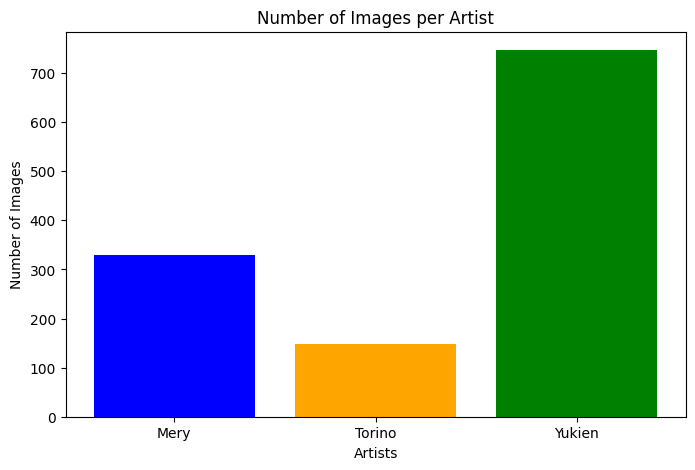

In [9]:
import os
import matplotlib.pyplot as plt

# Define artist labels manually
artist_labels = {0: "Mery", 1: "Torino", 2: "Yukien"}

# Count images per artist
image_counts = [len(os.listdir(os.path.join(dataset_path, folder))) for folder in artist_folders]

# Rename x-axis labels using dictionary
artist_names = [artist_labels[i] for i in range(len(artist_folders))]  # Convert indices to names

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(artist_names, image_counts, color=['blue', 'orange', 'green'])
plt.xlabel("Artists")
plt.ylabel("Number of Images")
plt.title("Number of Images per Artist")
# plt.xticks(rotation=15)
plt.show()


In [10]:
print(image_counts)

[330, 148, 747]


The dataset is relatively small, with Mery having 330 images, Torino 148, and Yukien 760 images. To improve the model's performance, it may be necessary to find additional artists with 500+ works or consider oversampling the existing dataset to balance the distribution.

In [11]:
# TODO: Oversampling: since the dataset is imbalanced

In [12]:
# Define the target image size for resizing the images during loading
image_size = (180, 180)

# Define the batch size for processing images in groups during training
batch_size = 128

# Load the image dataset from the specified directory, with 80% for training and 20% for validation
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,  # Path to the directory containing the image data
    validation_split=0.2,     # Split the data into training (80%) and validation (20%) sets
    subset="both",            # Indicate that we want both training and validation data
    seed=1,                   # Set a random seed for reproducibility of the split
    image_size=image_size,    # Resize images to the specified dimensions (180x180)
    batch_size=batch_size,    # Set the batch size for loading images
)


Found 1225 files belonging to 3 classes.
Using 980 files for training.
Using 245 files for validation.


Show 9 images from the dataset labeled with name of artist

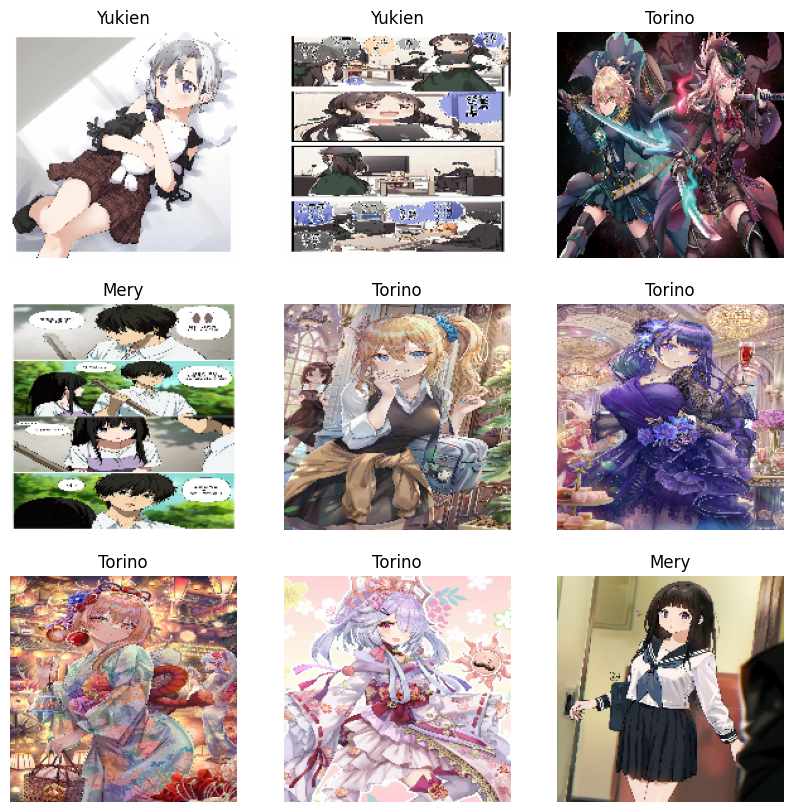

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(artist_labels[int(labels[i])])  # Show artist name instead of number
        plt.axis("off")


We apply data augmentation by randomly zooming in on images by 50%, flipping them horizontally, and then applying a random rotation.

In [14]:
tf.random.set_seed(1)

data_augmentation = keras.Sequential(
    [
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    ]
)


In [15]:
# Apply data_augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

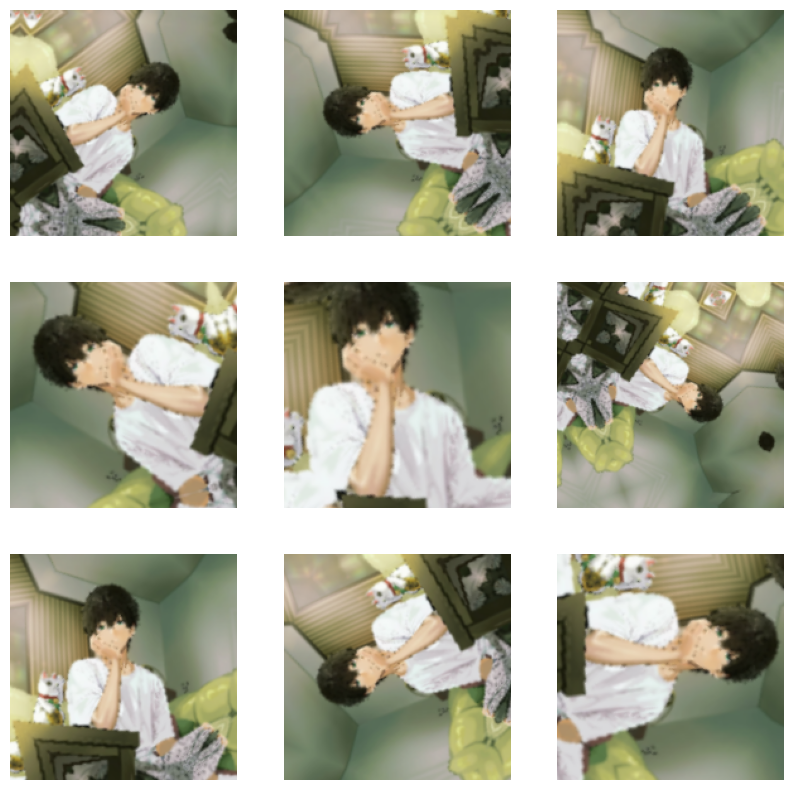

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): # return one batch of images: 128
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Building the Model


In [17]:
from tensorflow.keras.layers import Dropout  # Import Dropout to prevent overfitting

# Function to create a neural network model
# TODO: optimize the architecture
# TODO: use KerasTuner for hyperparameter tuning
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)  # Define input layer with the given shape

    # Entry block: Normalize pixel values (0-255) to a range of 0-1
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Flatten the image into a 1D vector
    x = layers.Flatten()(x)

    # Use 2 Dense Layers
    x = layers.Dense(392, activation="relu")(x)

    # Dropout layer to reduce overfitting (randomly drops 30% of neurons)
    x = Dropout(0.3)(x)

    x = layers.Dense(196, activation="relu")(x)

    # Another Dropout layer
    x = Dropout(0.3)(x)

    # Define activation function and output units based on the number of classes
    if num_classes == 2:
        activation = "sigmoid"  # Sigmoid for binary classification
        units = 1
    else:
        activation = "softmax"  # Softmax for multi-class classification
        units = num_classes

    # Output layer with the selected activation function
    outputs = layers.Dense(units, activation=activation)(x)

    # Create and return the model
    return keras.Model(inputs, outputs)


# Create the model with the specified input shape and 3 output classes
model = make_model(input_shape=image_size + (3,), num_classes=3)


#### Training the Model


In [18]:
epochs = 5

# Compile the model with an optimizer, loss function, and evaluation metrics
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), # small learning rate (0.0001)
    loss="sparse_categorical_crossentropy",  # Loss function for multi-class classification with integer labels
    metrics=["accuracy"],
)

# Callbacks
callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", # Stop training when validation loss stops improving
        patience=1,  # Allow 1 epoch of no improvement before stopping
        restore_best_weights=True  # Restore best weights when stopping early
    ),
]

# Train model
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4271 - loss: 5.0976 - val_accuracy: 0.2571 - val_loss: 2.9657
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4471 - loss: 4.5328 - val_accuracy: 0.2449 - val_loss: 1.9009
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 936ms/step - accuracy: 0.4176 - loss: 3.2697 - val_accuracy: 0.6408 - val_loss: 1.3128
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.4788 - loss: 2.1113 - val_accuracy: 0.6204 - val_loss: 1.0068
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 985ms/step - accuracy: 0.4824 - loss: 1.5319 - val_accuracy: 0.6204 - val_loss: 0.9409


# Plans moving forward
- Oversampling: Address the class imbalance in the dataset.
- Hyperparameter Tuning: Consider using KerasTuner for a systematic search of the best model configuration.
- Model Architecture Optimization: Explore ways to improve the architecture for better performance.
- Feature Extraction: Apply techniques like extracting line art, colors, and compositions, (e.g. zooming in to just the face) to generate more diverse training data.